Training a Physics-Informed Neural Network for control of dynamic system.

Use case: _Fed-Batch bioreactor with no product formation_

In [ ]:
import copy
import os
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.stats import qmc
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#################################################################   
####################Physics-Informed Neural Network #############
NUM_EPOCHS = 100000
LEARNING_RATE = 1e-4
NUM_COLLOCATION = 10000
PATIENCE = 1000
THRESHOLD = 1e-3
EARLY_STOPPING_EPOCH = 50000
NUM_SAMPLES = 3000

T_START = 0.0
T_END = 5.0
dt = 0.1

X_MIN = 3.0
X_MAX = 30.0
S_MIN = 0.01
S_MAX = 2.0
V_MIN = 1.0
V_MAX = 3.0
F_MIN = 0.0
F_MAX = 0.1

# --- Model Parameters ---
# MU_MAX = 0.86980    # 1/h
# K_S = 0.000123762    # g/l
# Y_XS = 0.435749      # g/g
S_F = 286           # g/l

# --- Model parameters estimated using PINN ---
MU_MAX = 0.8564
K_S    = 0.1707
Y_XS   = 0.4066


# Initial Conditions
X_0, S_0, V_0 = 5, 0.013, 1.7  # Biomass, Substrate, Volume

# ODE solver parameters
ODE_SOLVER = 'LSODA'

In [2]:
def numpy_to_tensor(array, requires_grad=False):
    return torch.tensor(array, requires_grad=requires_grad, dtype=torch.float32).to(DEVICE).reshape(-1, 1)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

class PINN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.input = nn.Linear(input_dim, 64)
        self.hidden1 = nn.Linear(64, 1024)
        self.hidden  = nn.Linear(1024, 1024)
        self.hidden2 = nn.Linear(1024, 64)
        self.output = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden(x))
        x = torch.tanh(self.hidden2(x))
        x = self.output(x)
        return x

In [3]:
def generate_dataset(num_samples: int = NUM_SAMPLES, sampling_method: str = 'lhs') -> tuple:
    """Generate dataset of random multiple initial conditions and control actions"""
    df = pd.DataFrame(columns=['t', 'X', 'S', 'V', 'F'])
    if sampling_method == 'uniform':
        df['X'] = np.random.uniform(X_MIN, X_MAX, num_samples)
        df['S'] = np.random.uniform(S_MIN, S_MAX, num_samples)
        df['V'] = np.random.uniform(V_MIN, V_MAX, num_samples)
        df['F'] = np.random.uniform(F_MIN, F_MAX, num_samples)
        df['t'] = 0.0 # initial time (always 0)
    elif sampling_method == 'lhs':
        sampler = qmc.LatinHypercube(d=4)
        lhs_samples = sampler.random(n=num_samples)
        scaled_samples = qmc.scale(lhs_samples, [X_MIN, S_MIN, V_MIN, F_MIN], [X_MAX, S_MAX, V_MAX, F_MAX])
        df = pd.DataFrame(scaled_samples, columns=['X', 'S', 'V', 'F'])
        df['t'] = 0.0
        
    t_train = numpy_to_tensor(df['t'].values, requires_grad=True)
    X_train = numpy_to_tensor(df['X'].values)
    S_train = numpy_to_tensor(df['S'].values)
    V_train = numpy_to_tensor(df['V'].values)
    F_train = numpy_to_tensor(df['F'].values)
    
    in_train = torch.cat([t_train, X_train, S_train, V_train, F_train], dim=1)
    out_train = torch.cat([X_train, S_train, V_train], dim=1)
    
    return in_train, out_train

def loss_fn(net: nn.Module, sampling_method: str = 'lhs') -> torch.Tensor:
    if sampling_method == 'uniform':
        t_col = numpy_to_tensor(np.random.uniform(T_START, dt, NUM_COLLOCATION), requires_grad=True)
        X0_col = numpy_to_tensor(np.random.uniform(X_MIN, X_MAX, NUM_COLLOCATION))
        S0_col = numpy_to_tensor(np.random.uniform(S_MIN, S_MAX, NUM_COLLOCATION))
        V0_col = numpy_to_tensor(np.random.uniform(V_MIN, V_MAX, NUM_COLLOCATION))
        F_col  = numpy_to_tensor(np.random.uniform(F_MIN, F_MAX, NUM_COLLOCATION))
    elif sampling_method == 'lhs':
        sampler = qmc.LatinHypercube(d=5)
        lhs_samples = sampler.random(n=NUM_COLLOCATION)
        scaled_samples = qmc.scale(lhs_samples, [T_START, X_MIN, S_MIN, V_MIN, F_MIN], [dt, X_MAX, S_MAX, V_MAX, F_MAX])
        t_col = numpy_to_tensor(scaled_samples[:, 0], requires_grad=True)
        X0_col = numpy_to_tensor(scaled_samples[:, 1])
        S0_col = numpy_to_tensor(scaled_samples[:, 2])
        V0_col = numpy_to_tensor(scaled_samples[:, 3])
        F_col  = numpy_to_tensor(scaled_samples[:, 4])
    
    u_col = torch.cat([t_col, X0_col, S0_col, V0_col, F_col], dim=1)
    preds = net.forward(u_col)

    X_pred = preds[:, 0].view(-1, 1)
    S_pred = preds[:, 1].view(-1, 1)
    # V_pred = preds[:, 2].view(-1, 1)
    V_pred = V0_col.view(-1, 1) + F_col.view(-1, 1) * t_col.view(-1, 1) # not used

    dXdt_pred = grad(X_pred, t_col)
    # dSdt_pred = grad(S_pred, t_col) 
    # dVdt_pred = grad(V_pred, t_col) # not used

    mu = MU_MAX * S_pred / (K_S + S_pred)

    # residuals
    rhs_X = mu * X_pred - (F_col / V_pred) * X_pred
    rhs_S = - (mu * X_pred) / Y_XS + (F_col / V_pred) * (S_F - S_pred)
    # rhs_V = F_col

    error_dXdt = dXdt_pred - rhs_X
    error_dSdt = 0.0 - rhs_S
    # error_dVdt = dVdt_pred - rhs_V

    # average residual squared loss
    w_X, w_S, w_V = 0.8, 0.2, 0.0
    loss_ode = torch.mean(error_dXdt**2) * w_X + \
               torch.mean(error_dSdt**2) * w_S 

    return loss_ode

In [4]:
in_train, out_train = generate_dataset()

print(f'Input shape: {in_train.shape}')
print(f'Output shape: {out_train.shape}')

Input shape: torch.Size([3000, 5])
Output shape: torch.Size([3000, 3])


In [5]:
model_name = "pinc_model_br_v3.pth"
model_exists = os.path.exists(f'./models/{model_name}')

if model_exists:
    # Load the model
    net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
    net.load_state_dict(torch.load(f'./models/{model_name}', weights_only=True))
    net.eval()
else:
    # Main
    net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.75)

    # Loss weights
    w_data, w_ode, w_ic = 1, 1, 0.0

    # Initialize early stopping variables
    best_loss = float("inf")
    best_model_weights = None
    patience = PATIENCE
    threshold = THRESHOLD
    pretrain_epochs = 0
    
    for epoch in tqdm(range(NUM_EPOCHS)):
        optimizer.zero_grad()
        preds = net.forward(in_train)
        X_pred = preds[:, 0].view(-1, 1)
        S_pred = preds[:, 1].view(-1, 1)
        V_pred = preds[:, 2].view(-1, 1)
        
        w_X, w_S, w_V = 0.7, 0.2, 0.1
        loss_data = torch.mean((X_pred - out_train[:, 0].view(-1, 1))**2) * w_X + \
                    torch.mean((S_pred - out_train[:, 1].view(-1, 1))**2) * w_S + \
                    torch.mean((V_pred - out_train[:, 2].view(-1, 1))**2) * w_V
        
        if epoch < pretrain_epochs:
            loss = loss_data * w_data
        else:
            loss_ode = loss_fn(net)
            loss = w_data * loss_data + w_ode * loss_ode
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if epoch % 1000 == 0:
            if epoch < pretrain_epochs:
                print(f"Epoch {epoch}: Loss = {loss_data.item():.4f}")
            else:
                print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Data Loss = {loss_data.item():.4f}, ODE Loss = {loss_ode.item():.4f}")
        
        # Early stopping
        if epoch >= EARLY_STOPPING_EPOCH:
            if loss.item() < best_loss - threshold:
                best_loss = loss.item()
                best_model_weights = copy.deepcopy(net.state_dict())
                patience = PATIENCE
            else:
                patience -= 1
                if patience <= 0:
                    print(f"Early stopping at epoch {epoch}. Best loss: {best_loss:.4f} at epoch {epoch - PATIENCE}.")
                    break

    # Load best model weights
    if best_model_weights is not None:
        net.load_state_dict(best_model_weights)
        net.eval()
        print("Loaded best model weights.")
    else:
        print("No model weights to load.")
        net.eval()

    # Save the model
    torch.save(net.state_dict(), f'./models/{model_name}')


  0%|          | 3/100000 [00:00<2:17:58, 12.08it/s]

Epoch 0: Loss = 251.6056, Data Loss = 233.2130, ODE Loss = 18.3926


  1%|          | 1004/100000 [00:50<1:31:29, 18.04it/s]

Epoch 1000: Loss = 81.8083, Data Loss = 72.0372, ODE Loss = 9.7711


  2%|▏         | 2004/100000 [01:44<1:29:05, 18.33it/s]

Epoch 2000: Loss = 35.6792, Data Loss = 31.4424, ODE Loss = 4.2368


  3%|▎         | 3004/100000 [02:38<1:28:26, 18.28it/s]

Epoch 3000: Loss = 18.4169, Data Loss = 16.3148, ODE Loss = 2.1021


  4%|▍         | 4004/100000 [03:32<1:26:29, 18.50it/s]

Epoch 4000: Loss = 8.9394, Data Loss = 7.9375, ODE Loss = 1.0019


  5%|▌         | 5004/100000 [04:26<1:25:31, 18.51it/s]

Epoch 5000: Loss = 5.1327, Data Loss = 4.3846, ODE Loss = 0.7481


  6%|▌         | 6004/100000 [05:21<1:24:58, 18.44it/s]

Epoch 6000: Loss = 2.8102, Data Loss = 2.2996, ODE Loss = 0.5106


  7%|▋         | 7004/100000 [06:14<1:23:05, 18.65it/s]

Epoch 7000: Loss = 1.8085, Data Loss = 1.3789, ODE Loss = 0.4295


  8%|▊         | 8004/100000 [07:08<1:22:07, 18.67it/s]

Epoch 8000: Loss = 1.1399, Data Loss = 0.8344, ODE Loss = 0.3055


  9%|▉         | 9004/100000 [08:01<1:20:18, 18.89it/s]

Epoch 9000: Loss = 0.8467, Data Loss = 0.6027, ODE Loss = 0.2440


 10%|█         | 10004/100000 [08:55<1:20:07, 18.72it/s]

Epoch 10000: Loss = 0.6897, Data Loss = 0.4671, ODE Loss = 0.2225


 11%|█         | 11004/100000 [09:48<1:19:50, 18.58it/s]

Epoch 11000: Loss = 0.5880, Data Loss = 0.4084, ODE Loss = 0.1796


 12%|█▏        | 12004/100000 [10:42<1:17:43, 18.87it/s]

Epoch 12000: Loss = 0.5513, Data Loss = 0.3763, ODE Loss = 0.1749


 13%|█▎        | 13004/100000 [11:35<1:16:45, 18.89it/s]

Epoch 13000: Loss = 0.5312, Data Loss = 0.3594, ODE Loss = 0.1718


 14%|█▍        | 14004/100000 [12:28<1:16:19, 18.78it/s]

Epoch 14000: Loss = 0.5030, Data Loss = 0.3483, ODE Loss = 0.1547


 15%|█▌        | 15004/100000 [13:21<1:15:22, 18.79it/s]

Epoch 15000: Loss = 0.4921, Data Loss = 0.3453, ODE Loss = 0.1468


 16%|█▌        | 16004/100000 [14:15<1:14:46, 18.72it/s]

Epoch 16000: Loss = 0.4873, Data Loss = 0.3411, ODE Loss = 0.1463


 17%|█▋        | 17004/100000 [15:08<1:14:40, 18.53it/s]

Epoch 17000: Loss = 0.4781, Data Loss = 0.3381, ODE Loss = 0.1400


 18%|█▊        | 18004/100000 [16:01<1:12:32, 18.84it/s]

Epoch 18000: Loss = 0.4699, Data Loss = 0.3357, ODE Loss = 0.1342


 19%|█▉        | 19004/100000 [16:54<1:12:27, 18.63it/s]

Epoch 19000: Loss = 0.4699, Data Loss = 0.3345, ODE Loss = 0.1354


 20%|██        | 20004/100000 [17:48<1:10:49, 18.83it/s]

Epoch 20000: Loss = 0.4548, Data Loss = 0.3343, ODE Loss = 0.1205


 21%|██        | 21004/100000 [18:41<1:10:03, 18.79it/s]

Epoch 21000: Loss = 0.4538, Data Loss = 0.3321, ODE Loss = 0.1217


 22%|██▏       | 22004/100000 [19:34<1:09:48, 18.62it/s]

Epoch 22000: Loss = 0.4557, Data Loss = 0.3327, ODE Loss = 0.1231


 23%|██▎       | 23004/100000 [20:27<1:08:41, 18.68it/s]

Epoch 23000: Loss = 0.4527, Data Loss = 0.3322, ODE Loss = 0.1205


 24%|██▍       | 24004/100000 [21:21<1:07:23, 18.79it/s]

Epoch 24000: Loss = 0.4524, Data Loss = 0.3299, ODE Loss = 0.1225


 25%|██▌       | 25004/100000 [22:14<1:06:23, 18.83it/s]

Epoch 25000: Loss = 0.4418, Data Loss = 0.3307, ODE Loss = 0.1111


 26%|██▌       | 26004/100000 [23:07<1:05:50, 18.73it/s]

Epoch 26000: Loss = 0.4437, Data Loss = 0.3306, ODE Loss = 0.1131


 27%|██▋       | 27004/100000 [24:00<1:04:37, 18.82it/s]

Epoch 27000: Loss = 0.4380, Data Loss = 0.3305, ODE Loss = 0.1075


 28%|██▊       | 28004/100000 [24:53<1:03:51, 18.79it/s]

Epoch 28000: Loss = 0.4395, Data Loss = 0.3300, ODE Loss = 0.1095


 29%|██▉       | 29004/100000 [25:46<1:02:37, 18.90it/s]

Epoch 29000: Loss = 0.4565, Data Loss = 0.3291, ODE Loss = 0.1274


 30%|███       | 30004/100000 [26:39<1:01:03, 19.10it/s]

Epoch 30000: Loss = 0.4549, Data Loss = 0.3296, ODE Loss = 0.1253


 31%|███       | 31004/100000 [27:32<1:00:44, 18.93it/s]

Epoch 31000: Loss = 0.4450, Data Loss = 0.3295, ODE Loss = 0.1155


 32%|███▏      | 32004/100000 [28:24<1:00:09, 18.84it/s]

Epoch 32000: Loss = 0.4510, Data Loss = 0.3297, ODE Loss = 0.1213


 33%|███▎      | 33004/100000 [29:17<58:58, 18.93it/s]  

Epoch 33000: Loss = 0.4442, Data Loss = 0.3292, ODE Loss = 0.1151


 34%|███▍      | 34004/100000 [30:10<58:30, 18.80it/s]

Epoch 34000: Loss = 0.4401, Data Loss = 0.3302, ODE Loss = 0.1099


 35%|███▌      | 35004/100000 [31:03<57:24, 18.87it/s]

Epoch 35000: Loss = 0.4364, Data Loss = 0.3285, ODE Loss = 0.1079


 36%|███▌      | 36004/100000 [31:56<56:22, 18.92it/s]

Epoch 36000: Loss = 0.4388, Data Loss = 0.3280, ODE Loss = 0.1109


 37%|███▋      | 37004/100000 [32:48<55:34, 18.89it/s]

Epoch 37000: Loss = 0.4336, Data Loss = 0.3285, ODE Loss = 0.1051


 38%|███▊      | 38004/100000 [33:41<54:47, 18.86it/s]

Epoch 38000: Loss = 0.4449, Data Loss = 0.3280, ODE Loss = 0.1169


 39%|███▉      | 39004/100000 [34:34<53:26, 19.02it/s]

Epoch 39000: Loss = 0.4459, Data Loss = 0.3286, ODE Loss = 0.1172


 40%|████      | 40004/100000 [35:27<52:40, 18.98it/s]

Epoch 40000: Loss = 0.4365, Data Loss = 0.3286, ODE Loss = 0.1079


 41%|████      | 41004/100000 [36:20<52:18, 18.80it/s]

Epoch 41000: Loss = 0.4446, Data Loss = 0.3285, ODE Loss = 0.1161


 42%|████▏     | 42004/100000 [37:13<50:50, 19.01it/s]

Epoch 42000: Loss = 0.4296, Data Loss = 0.3284, ODE Loss = 0.1013


 43%|████▎     | 43004/100000 [38:05<50:24, 18.84it/s]

Epoch 43000: Loss = 0.4345, Data Loss = 0.3283, ODE Loss = 0.1062


 44%|████▍     | 44004/100000 [38:58<49:30, 18.85it/s]

Epoch 44000: Loss = 0.4319, Data Loss = 0.3280, ODE Loss = 0.1039


 45%|████▌     | 45004/100000 [39:51<48:28, 18.91it/s]

Epoch 45000: Loss = 0.4429, Data Loss = 0.3283, ODE Loss = 0.1146


 46%|████▌     | 46004/100000 [40:45<47:42, 18.86it/s]

Epoch 46000: Loss = 0.4311, Data Loss = 0.3280, ODE Loss = 0.1030


 47%|████▋     | 47004/100000 [41:38<46:59, 18.79it/s]

Epoch 47000: Loss = 0.4377, Data Loss = 0.3282, ODE Loss = 0.1094


 48%|████▊     | 48004/100000 [42:31<45:55, 18.87it/s]

Epoch 48000: Loss = 0.4452, Data Loss = 0.3279, ODE Loss = 0.1173


 49%|████▉     | 49004/100000 [43:24<45:15, 18.78it/s]

Epoch 49000: Loss = 0.4455, Data Loss = 0.3277, ODE Loss = 0.1178


 50%|█████     | 50004/100000 [44:17<44:29, 18.73it/s]

Epoch 50000: Loss = 0.4309, Data Loss = 0.3281, ODE Loss = 0.1029


 51%|█████     | 51004/100000 [45:10<43:36, 18.73it/s]

Epoch 51000: Loss = 0.4326, Data Loss = 0.3281, ODE Loss = 0.1045


 51%|█████     | 51094/100000 [45:15<43:19, 18.81it/s]

Early stopping at epoch 51094. Best loss: 0.4166 at epoch 50094.
Loaded best model weights.


In [6]:
# Load the model
net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)

net.load_state_dict(torch.load(f'./models/{model_name}', weights_only=True))
net.eval()

def flow_rate(t: float) -> float:
    """Flow rate as a function of time"""
    if t < 0.5:
        return 0.01
    elif t < 5.0:
        return 0.1
    else:
        return 0.00

# System dynamics
def system_dynamics(t: float, y: float, F: Union[callable, float]) -> np.array:
    X, S, V = y
    Fs = F(t) if callable(F) else F
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (Fs / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (Fs / V) * (S_F - S)
    dV_dt = Fs
    return np.array([dX_dt, dS_dt, dV_dt])

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval, rtol=1e-6, atol=1e-12)
    # sol.y = np.maximum(sol.y, 0)
    return sol

sol = solve_ode(system_dynamics, t_span=[T_START, T_END], y0=[X_0, S_0, V_0], method=ODE_SOLVER, \
                t_eval=np.arange(T_START, T_END, dt), args=(flow_rate,))
df = pd.DataFrame(sol.y.T, columns=['X', 'S', 'V'])
df['Time'] = sol.t

T_s = 0.1
t_test = numpy_to_tensor(np.array([df['Time'].values]))
X_test = numpy_to_tensor(np.array([df['X'].values]))
S_test = numpy_to_tensor(np.array([df['S'].values]))
V_test = numpy_to_tensor(np.array([df['V'].values]))
F_test = numpy_to_tensor(np.array([flow_rate(t) for t in df['Time'].values]))
u_test = torch.cat([t_test, X_test, S_test, V_test, F_test], dim=1)
x_test = torch.cat([X_test, S_test, V_test], dim=1)

X_0 = X_test[0]
S_0 = S_test[0]
V_0 = V_test[0]
F_0 = F_test[0]

X_preds = []
S_preds = []
V_preds = []

net.eval()
for i in range(len(u_test)):

    if i == 0:
        X_preds.append(X_0.item())
        S_preds.append(S_0.item())
        V_preds.append(V_0.item())
        continue

    x_k = net.forward(torch.tensor([T_s, X_0, S_0, V_0, F_0], dtype=torch.float32).to(DEVICE))
    X_0 = X_test[i]
    S_0 = S_test[i]
    V_0 = V_test[i]
    F_0 = F_test[i]
    X_preds.append(x_k[0].item())
    S_preds.append(x_k[1].item())
    V_preds.append(x_k[2].item())

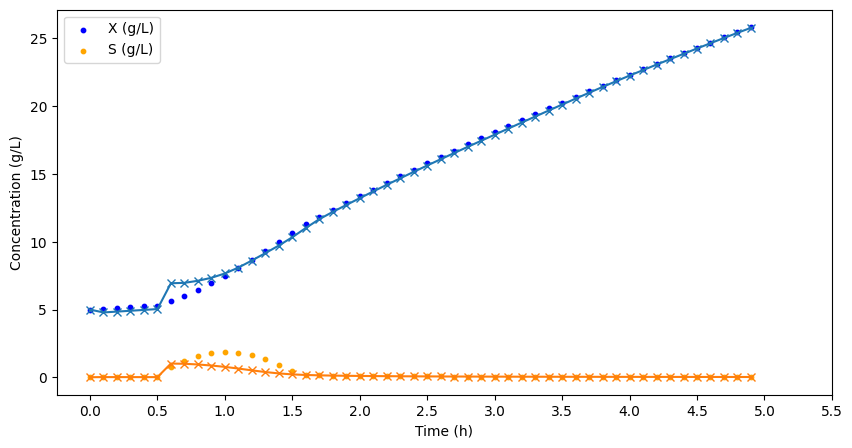

In [14]:
plt.figure(figsize=(10, 5))
plt.scatter(df['Time'], df['X'], label='X (g/L)', color='blue', s=10)
plt.scatter(df['Time'], df['S'], label='S (g/L)', color='orange', s=10)

plt.plot(t_test.detach().cpu().numpy(), X_preds, marker='x', label="_X_pred")
plt.plot(t_test.detach().cpu().numpy(), S_preds, marker='x', label="_S_pred")
plt.ylabel("Concentration (g/L)")
plt.legend(loc="best") 

plt.xticks(np.arange(0, 6, 0.5))
plt.xlabel("Time (h)")
plt.show()